Training set size: (5087, 3198)
Test set size: (570, 3198)

Class distribution in the training set:
LABEL
1    5050
2      37
Name: count, dtype: int64

Class distribution in the test set:
LABEL
1    565
2      5
Name: count, dtype: int64

Step 3: Data Preparation...
New class distribution in the training set:
LABEL
0    2020
1    1010
Name: count, dtype: int64

Final shape of training data: (3030, 3197, 1)
Final shape of test data: (570, 3197, 1)

Step 4: Creating the CNN Model...

Step 5: Model Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.6254 - loss: 0.6664 - val_accuracy: 0.9912 - val_loss: 0.4225
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.6851 - loss: 0.6150 - val_accuracy: 0.9912 - val_loss: 0.4473
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.7085 - loss: 0.5939 - val_accuracy: 0.9912 - val_loss: 0.4697
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.6990 - loss: 0.5880 - val_accuracy: 0.9825 - val_loss: 0.4313
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.7364 - loss: 0.5610 - val_accuracy: 0.9842 - val_loss: 0.2373
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.7488 - loss: 0.5423 - val_accuracy: 0.9772 - val_loss: 0.2833
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - accuracy: 0.7907 - loss: 0.4799 - val_accuracy: 0.9649 - val_loss: 0.3527
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.7767 - loss: 0.5020 - val_accu

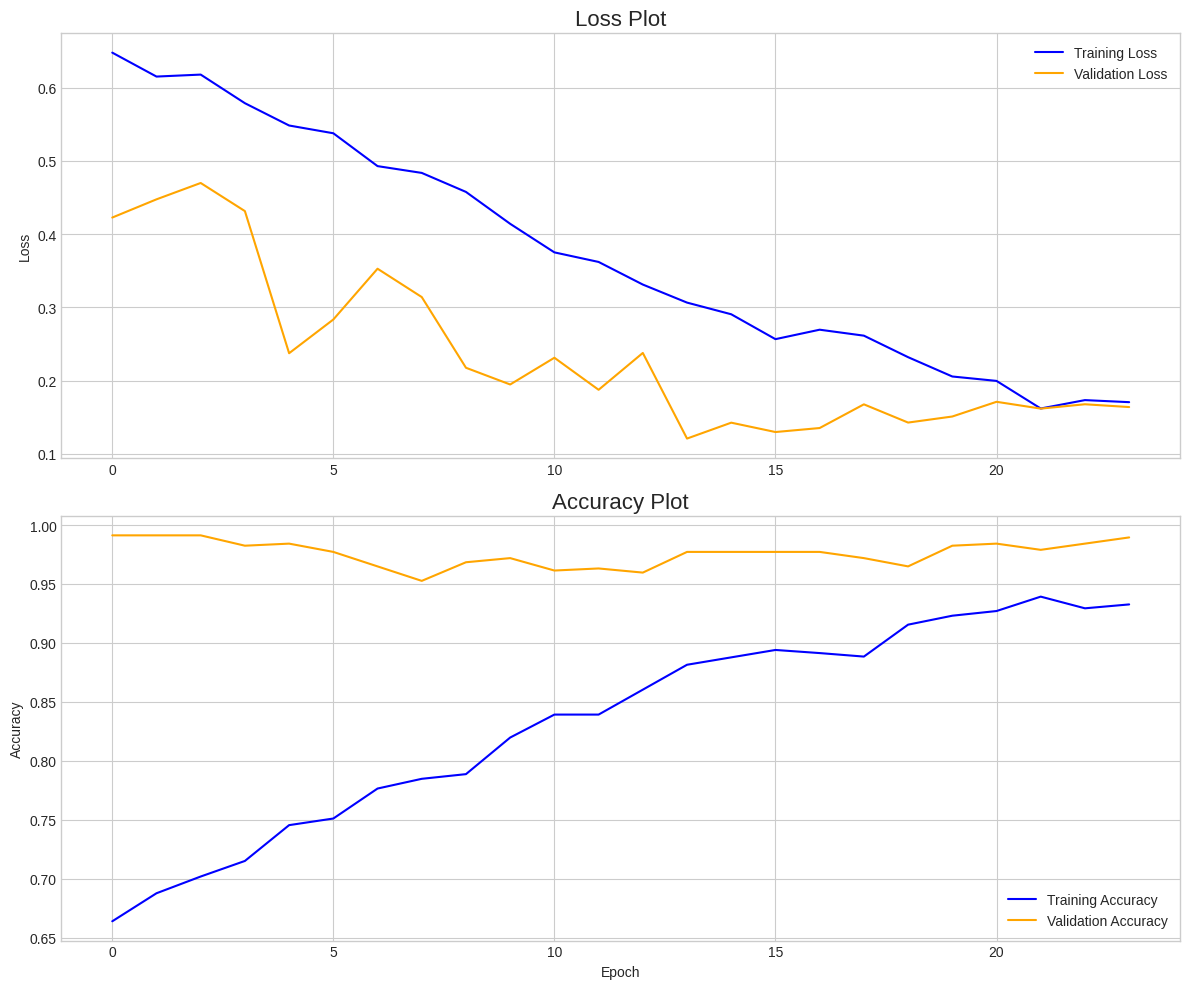

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Confusion Matrix:


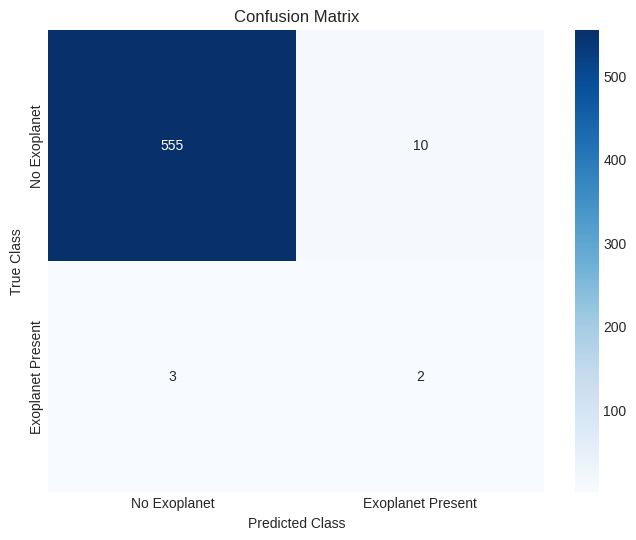


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       565
           1       0.17      0.40      0.24         5

    accuracy                           0.98       570
   macro avg       0.58      0.69      0.61       570
weighted avg       0.99      0.98      0.98       570

Additional Metrics:
Accuracy: 0.9772
Balanced Accuracy: 0.6912
ROC AUC Score: 0.5692


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, balanced_accuracy_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

TRAIN_DATA_PATH = 'exoTrain.csv'
TEST_DATA_PATH = 'exoTest.csv'

try:
    exo_train_df = pd.read_csv(TRAIN_DATA_PATH)
    exo_test_df = pd.read_csv(TEST_DATA_PATH)
except FileNotFoundError:
    print(f"Error: Data files not found. Ensure that TRAIN_DATA_PATH and TEST_DATA_PATH are specified correctly.")

    exo_train_df = pd.DataFrame()
    exo_test_df = pd.DataFrame()

if not exo_train_df.empty and not exo_test_df.empty:
    print("Training set size:", exo_train_df.shape)
    print("Test set size:", exo_test_df.shape)
    print("\nClass distribution in the training set:")
    print(exo_train_df['LABEL'].value_counts())
    print("\nClass distribution in the test set:")
    print(exo_test_df['LABEL'].value_counts())

    print("\nStep 3: Data Preparation...")

    exo_train_df['LABEL'] = exo_train_df['LABEL'].replace({1: 0, 2: 1})
    exo_test_df['LABEL'] = exo_test_df['LABEL'].replace({1: 0, 2: 1})

    X_train = exo_train_df.drop('LABEL', axis=1)
    y_train = exo_train_df['LABEL']
    X_test = exo_test_df.drop('LABEL', axis=1)
    y_test = exo_test_df['LABEL']

    def handle_outliers_vectorized(data):
        processed_data = data.copy()
        for i in range(processed_data.shape[0]):
            row = processed_data.iloc[i].values

            lower_bound = np.percentile(row, 1)
            upper_bound = np.percentile(row, 99)
            median = np.median(row)

            processed_data.iloc[i] = np.clip(row, lower_bound, upper_bound)
        return processed_data

    X_train = handle_outliers_vectorized(X_train)
    X_test = handle_outliers_vectorized(X_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    over = SMOTE(sampling_strategy=0.2, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

    print("New class distribution in the training set:")
    print(pd.Series(y_train_resampled).value_counts())

    X_train_final, y_train_final = shuffle(X_train_resampled, y_train_resampled, random_state=42)

    X_train_final = np.expand_dims(X_train_final, axis=-1)
    X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)
    print(f"\nFinal shape of training data: {X_train_final.shape}")
    print(f"Final shape of test data: {X_test_scaled.shape}")


    print("\nStep 4: Creating the CNN Model...")
    def create_cnn_model(input_shape):
        model = Sequential([

            Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),

            Conv1D(filters=32, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),

            Flatten(),

            Dense(64, activation='relu'),
            Dropout(0.5),

            Dense(32, activation='relu'),

            Dense(1, activation='sigmoid')
        ])

        lr_schedule = ExponentialDecay(
            initial_learning_rate=0.001,
            decay_steps=10000,
            decay_rate=0.9
        )

        optimizer = Adam(learning_rate=lr_schedule)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    input_shape = (X_train_final.shape[1], 1)
    model = create_cnn_model(input_shape)


    print("\nStep 5: Model Training...")

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_final,
        y_train_final,
        epochs=50,
        batch_size=64,
        validation_data=(X_test_scaled, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    print("\nStep 6: Model Evaluation...")

    def plot_training_history(history):
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        ax1.plot(history.history['loss'], label='Training Loss', color='blue')
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
        ax1.set_title('Loss Plot', fontsize=16)
        ax1.set_ylabel('Loss')
        ax1.legend()

        ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
        ax2.set_title('Accuracy Plot', fontsize=16)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

    plot_training_history(history)

    y_pred_proba = model.predict(X_test_scaled).flatten()

    y_pred_class = (y_pred_proba > 0.5).astype(int)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Exoplanet', 'Exoplanet Present'], yticklabels=['No Exoplanet', 'Exoplanet Present'])
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class))

    print("Additional Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_class):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

else:
    print("\nData processing and model training skipped because data files were not loaded.")